In [1]:
%load_ext autoreload
%matplotlib inline

# Anomaly Detection Evaluation

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
# B1, 30min
B1_30 = feature_extraction.load_features_from_file("features_b1_sw-30min*")
B1_30_s = preprocessing.scale_robust(B1_30)

# B2, 30min
B2_30 = feature_extraction.load_features_from_file("features_b2_sw-30min*")
B2_30_s = preprocessing.scale_robust(B2_30)

labels = db.query_elogbook_anomalies()

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.
Loading file '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min_2018-02-26.csv' instead.
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Model Selection

See images in src/scripts/figures/gmm.  
6/7/8 components causes best BIC scores and log likelihood scores for both beams.  
covariance_type 'full' has best scores.

## Evaluation

In [4]:
clf_B1 = GMM.GMM(n_components=6, covariance_type='tied')
B1_scored = clf_B1.fit_and_append_scores(B1_30_s)

clf_B2 = GMM.GMM(n_components=6, covariance_type='tied')
B2_scored = clf_B2.fit_and_append_scores(B2_30_s)

Function adds an extra column to the feature df with the log probs. The dataframe is also sorted with the first row having the lowest log probability. 

### Segmentation

In [5]:
segment_sizes = [200, 250, 500, 750, 1000]
segments_B1 = list(segmentation.generate_multiple_segments(B1_scored, segment_sizes))
segments_B2 = list(segmentation.generate_multiple_segments(B2_scored, segment_sizes))

New segmentation algorithm:
- start with N1 most anomalous points
- create segments
- add N2 more anomalous points
- if point IN segmentation: add it, do NOT expand existing segmentations  
  else: create new segmentation if clear from existing cluster (eg X hour boundary)
- repeat with more points

Current settings:
- max distance to segment: 12 hours
- metric for segment distance: "mean"
- boundary around existing segments: 12 hours
- sizes to segment: anomaly_sizes

In [6]:
for i, size in enumerate(segment_sizes):
    stats = evaluation.labels_vs_segments_beams(labels, segments_B1[i], segments_B2[i])
    display("segment size = {}".format(size), stats)

'segment size = 200'

beam       B1                            B2         \
                         segments points         score segments points   
2016-05-30 14:00:00    2      1.0    1.0  -1917.005431      0.0    0.0   
2016-06-05 17:18:00    2      0.0    0.0      0.000000      1.0    1.0   
2016-06-18 19:59:00    2      1.0    1.0   -914.927403      1.0    6.0   
2016-06-19 13:14:00    1      0.0    0.0      0.000000      0.0    0.0   
2016-06-30 21:23:00    1      0.0    0.0      0.000000      1.0    1.0   
2016-07-14 09:23:00    2      0.0    0.0      0.000000      0.0    0.0   
2016-07-24 22:19:48    1      1.0    1.0  -1053.920893      1.0    4.0   
2016-07-31 16:00:00    1      1.0    1.0  -1040.802974      1.0    3.0   
2016-08-02 17:28:00    1      0.0    0.0      0.000000      0.0    0.0   
2016-08-02 17:50:00    1      1.0    5.0 -22744.918645      0.0    0.0   
2016-08-03 08:05:00    1      0.0    0.0      0.000000      1.0    2.0   
2016-08-04 14:03:41    1      0.0    0.0      0.000000      0.0    0.0   
2016-08-21 20:00:00    2      0.0    0.0      0.000000      1.0    4.0   
2016-08-22 21:30:30    2      0.0    0.0      0.000000      0.0    0.0   
2016-08-23 06:53:47    1      1.0    2.0  -4038.897927      1.0    2.0   
2016-09-02 17:43:00    2      0.0    0.0      0.000000      0.0    0.0   

                                   
                            score  
2016-05-30 14:00:00      0.000000  
2016-06-05 17:18:00  -1831.923378  
2016-06-18 19:59:00  -8524.473730  
2016-06-19 13:14:00      0.000000  
2016-06-30 21:23:00  -1001.461716  
2016-07-14 09:23:00      0.000000  
2016-07-24 22:19:48  -4707.064101  
2016-07-31 16:00:00  -3831.177131  
2016-08-02 17:28:00      0.000000  
2016-08-02 17:50:00      0.000000  
2016-08-03 08:05:00  -2128.933469  
2016-08-04 14:03:41      0.000000  
2016-08-21 20:00:00 -12329.278073  
2016-08-22 21:30:30      0.000000  
2016-08-23 06:53:47  -2520.895806  
2016-09-02 17:43:00      0.000000

'segment size = 250'

beam       B1                            B2         \
                         segments points         score segments points   
2016-05-30 14:00:00    2      1.0    1.0  -1917.005431      0.0    0.0   
2016-06-05 17:18:00    2      0.0    0.0      0.000000      1.0    2.0   
2016-06-18 19:59:00    2      1.0    1.0   -914.927403      1.0    7.0   
2016-06-19 13:14:00    1      0.0    0.0      0.000000      0.0    0.0   
2016-06-30 21:23:00    1      0.0    0.0      0.000000      1.0    1.0   
2016-07-14 09:23:00    2      0.0    0.0      0.000000      0.0    0.0   
2016-07-24 22:19:48    1      1.0    1.0  -1053.920893      1.0    4.0   
2016-07-31 16:00:00    1      1.0    2.0  -1687.383833      1.0    3.0   
2016-08-02 17:28:00    1      0.0    0.0      0.000000      0.0    0.0   
2016-08-02 17:50:00    1      1.0    8.0 -24632.856622      0.0    0.0   
2016-08-03 08:05:00    1      0.0    0.0      0.000000      1.0    2.0   
2016-08-04 14:03:41    1      1.0    2.0  -1311.278733      0.0    0.0   
2016-08-21 20:00:00    2      0.0    0.0      0.000000      1.0    5.0   
2016-08-22 21:30:30    2      0.0    0.0      0.000000      0.0    0.0   
2016-08-23 06:53:47    1      1.0    2.0  -4038.897927      1.0    2.0   
2016-09-02 17:43:00    2      0.0    0.0      0.000000      0.0    0.0   

                                   
                            score  
2016-05-30 14:00:00      0.000000  
2016-06-05 17:18:00  -2342.249015  
2016-06-18 19:59:00  -9024.080860  
2016-06-19 13:14:00      0.000000  
2016-06-30 21:23:00  -1001.461716  
2016-07-14 09:23:00      0.000000  
2016-07-24 22:19:48  -4707.064101  
2016-07-31 16:00:00  -3831.177131  
2016-08-02 17:28:00      0.000000  
2016-08-02 17:50:00      0.000000  
2016-08-03 08:05:00  -2128.933469  
2016-08-04 14:03:41      0.000000  
2016-08-21 20:00:00 -12905.071791  
2016-08-22 21:30:30      0.000000  
2016-08-23 06:53:47  -2520.895806  
2016-09-02 17:43:00      0.000000

'segment size = 500'

beam       B1                            B2         \
                         segments points         score segments points   
2016-05-30 14:00:00    2      1.0    3.0  -2434.885535      1.0    2.0   
2016-06-05 17:18:00    2      1.0    3.0  -1218.981319      1.0    3.0   
2016-06-18 19:59:00    2      1.0    1.0   -914.927403      1.0    9.0   
2016-06-19 13:14:00    1      1.0    5.0  -6590.783581      0.0    0.0   
2016-06-30 21:23:00    1      1.0   19.0  -3862.621787      1.0    4.0   
2016-07-14 09:23:00    2      0.0    0.0      0.000000      0.0    0.0   
2016-07-24 22:19:48    1      1.0    1.0  -1053.920893      1.0    8.0   
2016-07-31 16:00:00    1      1.0    4.0  -2300.214534      1.0    4.0   
2016-08-02 17:28:00    1      1.0   43.0 -35727.827628      0.0    0.0   
2016-08-02 17:50:00    1      1.0   43.0 -35727.827628      0.0    0.0   
2016-08-03 08:05:00    1      0.0    0.0      0.000000      2.0    5.0   
2016-08-04 14:03:41    1      1.0    4.0  -2326.213319      0.0    0.0   
2016-08-21 20:00:00    2      1.0    2.0   -970.368380      1.0    8.0   
2016-08-22 21:30:30    2      1.0    4.0  -4934.064331      0.0    0.0   
2016-08-23 06:53:47    1      0.0    0.0      0.000000      1.0    4.0   
2016-09-02 17:43:00    2      0.0    0.0      0.000000      0.0    0.0   

                                   
                            score  
2016-05-30 14:00:00   -635.715653  
2016-06-05 17:18:00  -2599.573032  
2016-06-18 19:59:00  -9667.821441  
2016-06-19 13:14:00      0.000000  
2016-06-30 21:23:00  -1785.809209  
2016-07-14 09:23:00      0.000000  
2016-07-24 22:19:48  -5754.964598  
2016-07-31 16:00:00  -4081.075552  
2016-08-02 17:28:00      0.000000  
2016-08-02 17:50:00      0.000000  
2016-08-03 08:05:00  -2289.560434  
2016-08-04 14:03:41      0.000000  
2016-08-21 20:00:00 -13391.754324  
2016-08-22 21:30:30      0.000000  
2016-08-23 06:53:47  -3010.143896  
2016-09-02 17:43:00      0.000000

'segment size = 750'

beam       B1                            B2         \
                         segments points         score segments points   
2016-05-30 14:00:00    2      1.0    3.0  -2434.885535      1.0    3.0   
2016-06-05 17:18:00    2      1.0    3.0  -1218.981319      1.0    4.0   
2016-06-18 19:59:00    2      1.0    1.0   -914.927403      1.0    9.0   
2016-06-19 13:14:00    1      1.0   27.0 -10168.384948      1.0    1.0   
2016-06-30 21:23:00    1      1.0   42.0  -7725.556894      1.0   77.0   
2016-07-14 09:23:00    2      0.0    0.0      0.000000      0.0    0.0   
2016-07-24 22:19:48    1      1.0    1.0  -1053.920893      1.0    9.0   
2016-07-31 16:00:00    1      1.0    4.0  -2300.214534      1.0    4.0   
2016-08-02 17:28:00    1      1.0   52.0 -37247.605854      0.0    0.0   
2016-08-02 17:50:00    1      1.0   52.0 -37247.605854      0.0    0.0   
2016-08-03 08:05:00    1      0.0    0.0      0.000000      1.0    2.0   
2016-08-04 14:03:41    1      1.0    4.0  -2326.213319      1.0    5.0   
2016-08-21 20:00:00    2      1.0    3.0  -1149.938473      1.0   58.0   
2016-08-22 21:30:30    2      1.0    4.0  -4934.064331      0.0    0.0   
2016-08-23 06:53:47    1      0.0    0.0      0.000000      1.0    4.0   
2016-09-02 17:43:00    2      0.0    0.0      0.000000      0.0    0.0   

                                   
                            score  
2016-05-30 14:00:00   -785.888504  
2016-06-05 17:18:00  -2700.935130  
2016-06-18 19:59:00  -9667.821441  
2016-06-19 13:14:00   -150.690987  
2016-06-30 21:23:00 -10522.024811  
2016-07-14 09:23:00      0.000000  
2016-07-24 22:19:48  -5881.830601  
2016-07-31 16:00:00  -4081.075552  
2016-08-02 17:28:00      0.000000  
2016-08-02 17:50:00      0.000000  
2016-08-03 08:05:00  -2181.863234  
2016-08-04 14:03:41  -5173.655603  
2016-08-21 20:00:00 -19670.856430  
2016-08-22 21:30:30      0.000000  
2016-08-23 06:53:47  -3010.143896  
2016-09-02 17:43:00      0.000000

'segment size = 1000'

beam       B1                            B2         \
                         segments points         score segments points   
2016-05-30 14:00:00    2      1.0    3.0  -2434.885535      1.0    3.0   
2016-06-05 17:18:00    2      1.0    3.0  -1218.981319      1.0    4.0   
2016-06-18 19:59:00    2      1.0    1.0   -914.927403      1.0    9.0   
2016-06-19 13:14:00    1      1.0   61.0 -14721.498998      1.0    1.0   
2016-06-30 21:23:00    1      1.0  120.0 -18103.688431      1.0  109.0   
2016-07-14 09:23:00    2      1.0    1.0   -122.197432      0.0    0.0   
2016-07-24 22:19:48    1      1.0    1.0  -1053.920893      1.0   21.0   
2016-07-31 16:00:00    1      1.0    4.0  -2300.214534      1.0    4.0   
2016-08-02 17:28:00    1      1.0   64.0 -38888.472622      1.0    1.0   
2016-08-02 17:50:00    1      1.0   64.0 -38888.472622      1.0    1.0   
2016-08-03 08:05:00    1      0.0    0.0      0.000000      1.0    2.0   
2016-08-04 14:03:41    1      1.0    4.0  -2326.213319      1.0    5.0   
2016-08-21 20:00:00    2      1.0    3.0  -1149.938473      1.0   71.0   
2016-08-22 21:30:30    2      1.0    4.0  -4934.064331      0.0    0.0   
2016-08-23 06:53:47    1      0.0    0.0      0.000000      1.0    4.0   
2016-09-02 17:43:00    2      0.0    0.0      0.000000      0.0    0.0   

                                   
                            score  
2016-05-30 14:00:00   -785.888504  
2016-06-05 17:18:00  -2700.935130  
2016-06-18 19:59:00  -9667.821441  
2016-06-19 13:14:00   -150.690987  
2016-06-30 21:23:00 -13225.274706  
2016-07-14 09:23:00      0.000000  
2016-07-24 22:19:48  -6860.703812  
2016-07-31 16:00:00  -4081.075552  
2016-08-02 17:28:00    -87.843423  
2016-08-02 17:50:00    -87.843423  
2016-08-03 08:05:00  -2181.863234  
2016-08-04 14:03:41  -5173.655603  
2016-08-21 20:00:00 -20796.227974  
2016-08-22 21:30:30      0.000000  
2016-08-23 06:53:47  -3010.143896  
2016-09-02 17:43:00      0.000000

### Visualisation

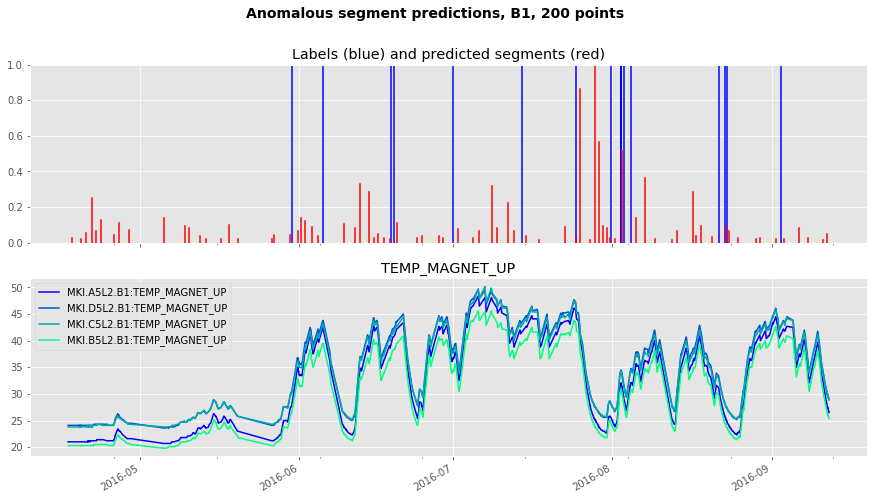

In [7]:
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_B1[0], labels, 'Anomalous segment predictions, B1, 200 points')

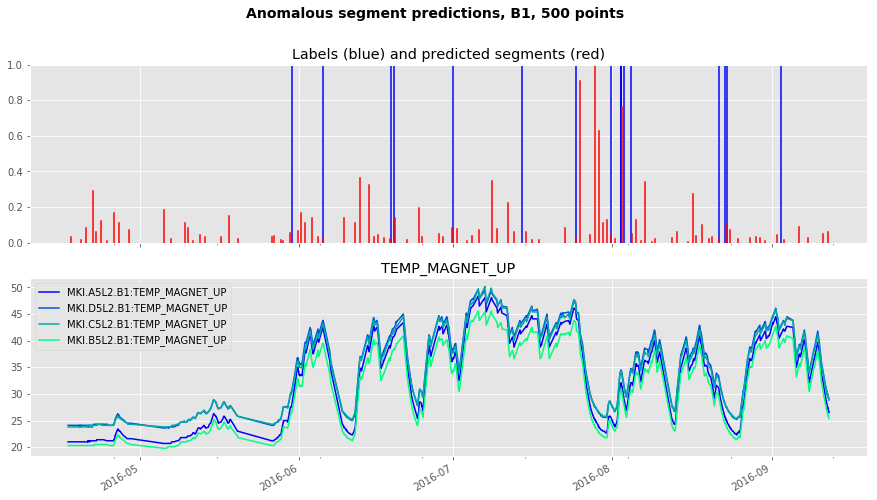

In [8]:
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_B1[2], labels, 'Anomalous segment predictions, B1, 500 points')

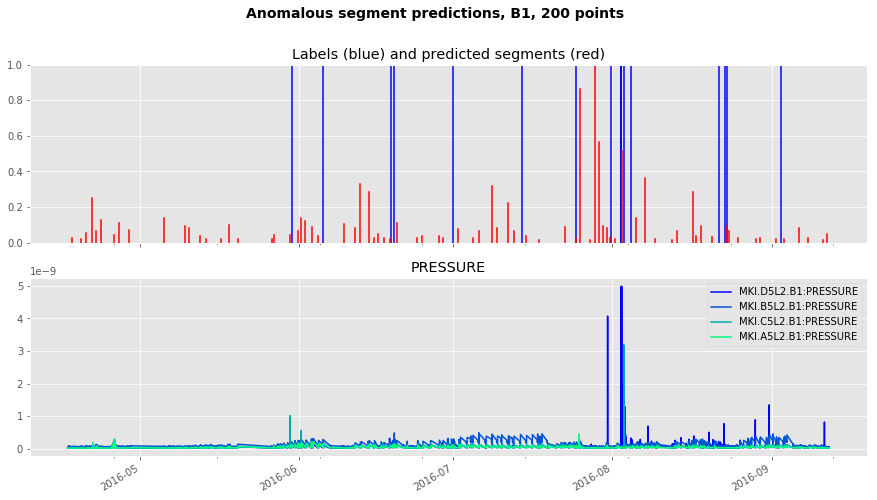

In [9]:
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_B1[0], labels, 'Anomalous segment predictions, B1, 200 points')

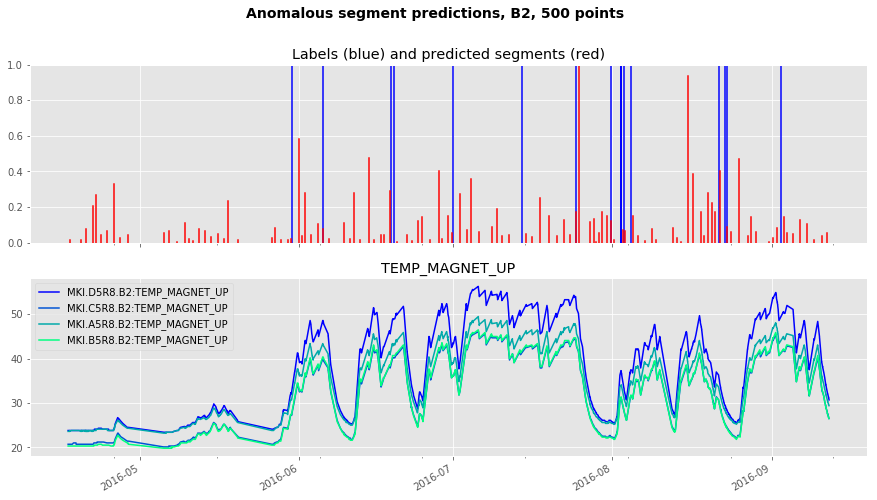

In [10]:
plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_B2[2], labels, 'Anomalous segment predictions, B2, 500 points')